In [407]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

## Enhance Raw Data

#### Load dataset

In [408]:
df = pd.read_csv("../data/final_dataset_mest.csv")

#### Unify variables

For more precise modeling, all variables were standardized to a common spatial unit (km²).

In [409]:
# unifying calculations (per km^2)
df['crime_density'] = df['crime_total'] / df['area_km2']
df['crime_attractor_density'] = (df['poi_pub'] + df['poi_nightclub'] + df['poi_bar']) / df['area_km2']
df['crime_generator_density'] = (df['poi_cafe'] + df['poi_museum'] + df['poi_attraction']) / df['area_km2']
df['tourist_density'] = df['nights_non_residents'] / df['area_km2']
df['foreigner_density'] = df['foreigners'] / df['area_km2']
df['university_density'] = df['people_university'] / df['area_km2']
df['airbnb_economy_density'] = df['airbnb_economy'] / df['area_km2']

In [410]:
# handle NaN values
df = df.fillna(0.0)
df.columns

Index(['district_name', 'population', 'area_km2', 'dist_center_km',
       'crime_total', 'crime_rate', 'crime_Burglary', 'crime_Disorder',
       'crime_Other', 'crime_Theft', 'crime_Violent', 'airbnb_count',
       'airbnb_density', 'airbnb_economy', 'airbnb_luxury',
       'airbnb_luxury_density', 'airbnb_entire_home', 'price_avg', 'poi_count',
       'poi_density', 'poi_attraction', 'poi_bar', 'poi_cafe', 'poi_hostel',
       'poi_hotel', 'poi_museum', 'poi_nightclub', 'poi_pub', 'poi_restaurant',
       'nights_non_residents', 'tourist_intensity', 'foreigners',
       'foreigner_ratio', 'people_university', 'university_ratio',
       'unemployment', 'mhd_count', 'mhd_density', 'crime_density',
       'crime_attractor_density', 'crime_generator_density', 'tourist_density',
       'foreigner_density', 'university_density', 'airbnb_economy_density'],
      dtype='object')

# Economy vs Luxury Airbnb Density

#### Construct Simple OLS Models

1. we predict crime_density in each Prague district
2. separate so called crime attractors (bars, pubs, nightclubs) and crime generators (cafes, museums, atractions) into two separated models
3. remove variables that are most likely multicolinear with crime_density (crime_total, crime_Burglary, crime_Disorder, crime_Other, crime_Theft,...)

In [411]:
lm_crime_economy = smf.ols('crime_density ~ dist_center_km + airbnb_economy_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_crime_luxury = smf.ols('crime_density ~ dist_center_km + airbnb_luxury_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

## Outliers

#### Analysing Outliers

In [412]:

def detect_outliers(linear_model):
    influence = linear_model.get_influence()
    n = int(linear_model.nobs)
    cooks_d = influence.cooks_distance[0]
    outliers = np.where(cooks_d > 4 / n)[0]
    return outliers, cooks_d

# outliers detection using Cook's distance
outliers_economy, cooks_d_economy = detect_outliers(lm_crime_economy)
print(f"Outliers of economy model: {outliers_economy}")

outliers_luxury, cooks_d_luxury = detect_outliers(lm_crime_luxury)
print(f"Outliers of luxury model: {outliers_luxury}")

Outliers of economy model: [ 0  2  8 11 15 19 21 46 56]
Outliers of luxury model: [ 0  2  4  8 11 15 19 21 46 56]


In [413]:
# plot outliers graph

def _plot_cooks(ax, cooks_d, outliers):
    n = len(cooks_d)
    x = np.arange(n)

    sns.barplot(x=x, y=cooks_d, ax=ax)
    ax.plot(x, np.full(n, 4 / n), linestyle="dotted", linewidth=1, color="red")

    for o in outliers:
        ax.text(o, cooks_d[o] + 0.005, str(o),
                ha="center", va="bottom", fontsize=8)

    ax.set_title("Cook’s Distance")
    ax.set_xlabel("Observation index")
    ax.set_ylabel("Cook’s distance")
    ax.set_xticks(range(0, n, max(1, n // 5)))

def outlier_single_plot(cooks_d, outliers):
    _, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

    _plot_cooks(axes[0], cooks_d, outliers)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

def outliers_double_plot(cooks_d_1, cooks_d_2, outliers_1, outliers_2):
    _, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

    _plot_cooks(axes[0], cooks_d_1, outliers_1)
    _plot_cooks(axes[1], cooks_d_2, outliers_2)

    plt.tight_layout()
    plt.show()


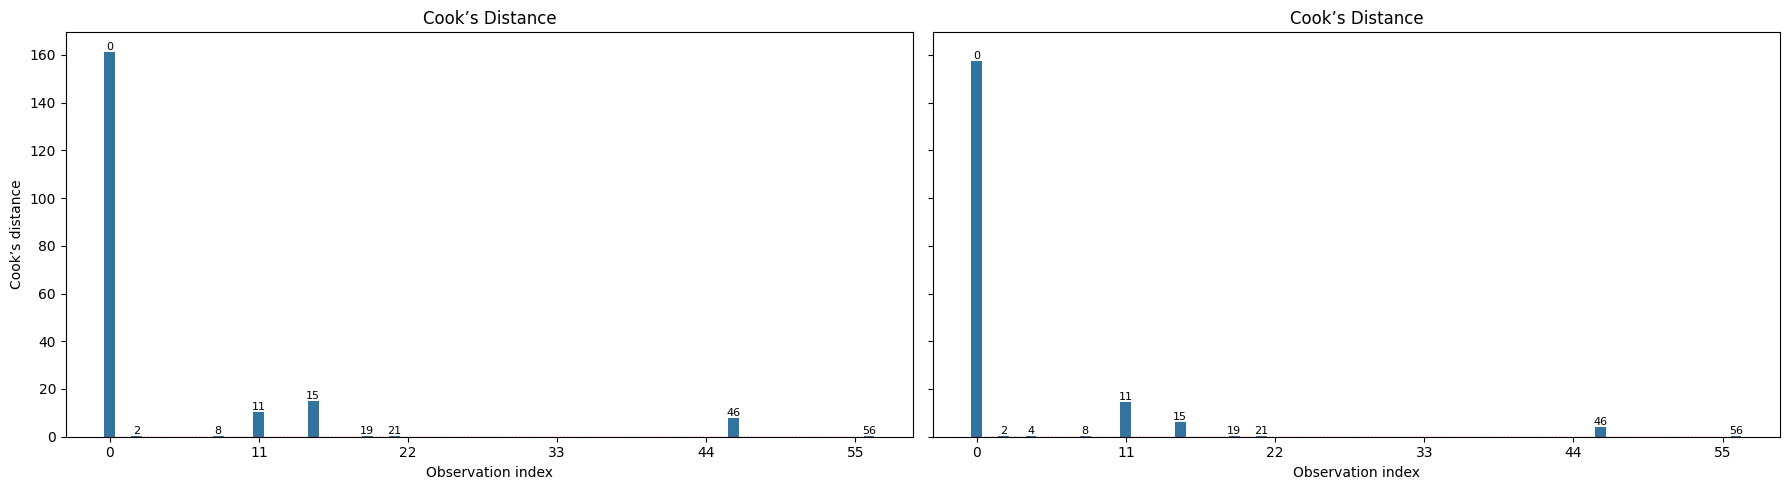

In [414]:
outliers_double_plot(cooks_d_economy, cooks_d_luxury, outliers_economy, outliers_luxury)

#### Removing Outliers

In [415]:
# same for the luxury and economy models
X_no_outliers_e = df.drop(outliers_economy)
X_no_outliers_l = df.drop(outliers_luxury)

In [416]:
# refit models without outliers
lm_crime_economy = smf.ols('crime_density ~ dist_center_km + airbnb_economy_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_no_outliers_e).fit()

lm_crime_luxury = smf.ols('crime_density ~ dist_center_km + airbnb_luxury_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_no_outliers_l).fit()

## Linearity and Homoscedasticity

#### Analysis of linearity and homoscedasticity quality

In [417]:
# plot two or single 'residuals vs fitted' fugures

def _plot_res_vs_fitted_ols(ax, model, title="OLS Residuals vs Fitted"):
    fitted = model.fittedvalues
    resid = model.resid

    sns.residplot(
        x=fitted,
        y=resid,
        lowess=True,
        line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8},
        ax=ax
    )

    # Identify top absolute residuals (by position)
    abs_resid = np.abs(resid)
    top_idx = np.argsort(abs_resid)[-5:]

    # Annotate
    for i in top_idx:
        ax.annotate(
            str(i),
            xy=(fitted.iloc[i], resid.iloc[i]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=9,
            color="C3"
        )

    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Residuals")
    ax.grid(True, alpha=0.3)

def res_vs_fitted_ols_single(model):
    _, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    _plot_res_vs_fitted_ols(axes[0], model)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

def res_vs_fitted_ols_double(model1, model2, titles=("Model 1", "Model 2")):
    _, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    _plot_res_vs_fitted_ols(axes[0], model1, f"OLS Residuals vs Fitted – {titles[0]}")
    _plot_res_vs_fitted_ols(axes[1], model2, f"OLS Residuals vs Fitted – {titles[1]}")

    plt.tight_layout()
    plt.show()


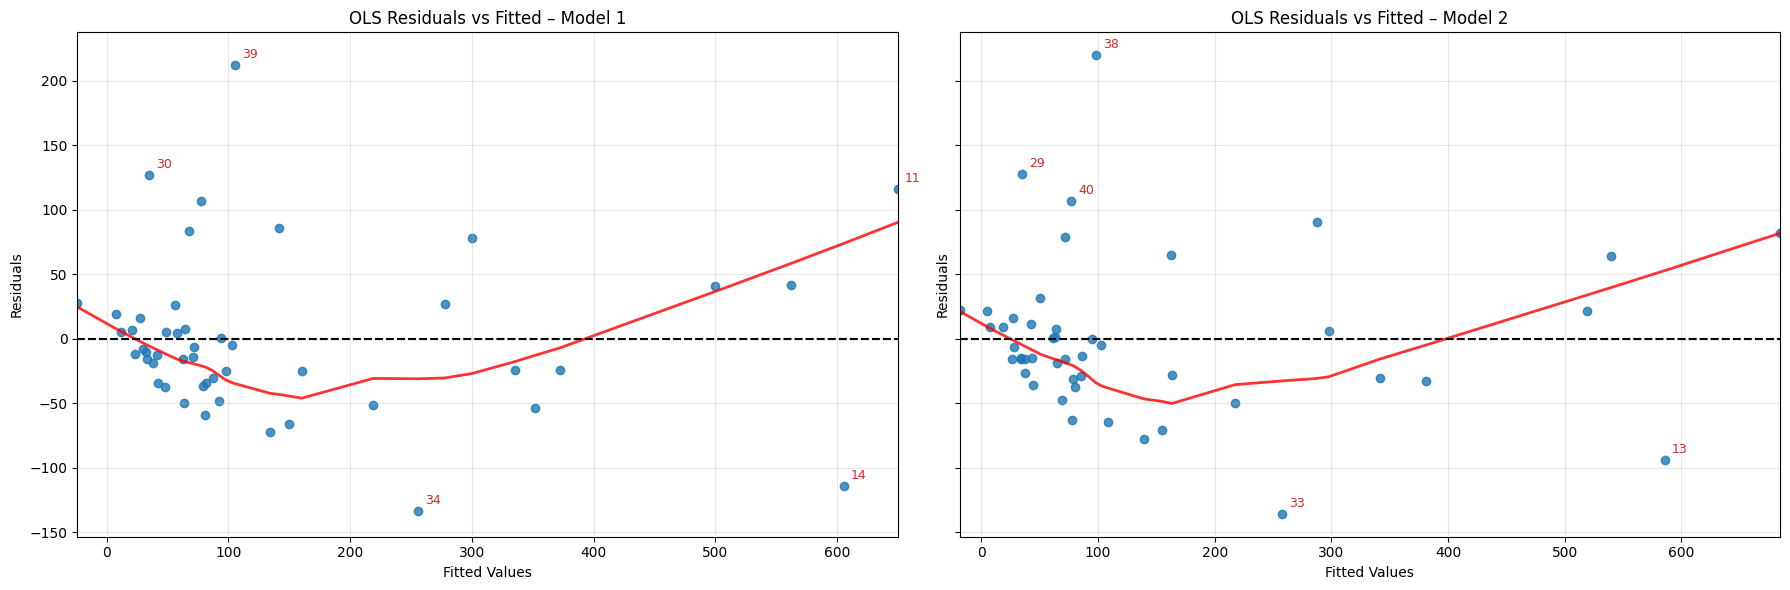

In [418]:
res_vs_fitted_ols_double(lm_crime_economy, lm_crime_luxury)

Residuals vs fitted plot shows significant heteroscedasticity and data is not linear. It is necessary to switch from simple OLS model to GLM model for futher data manupulation. In the next step we find proper feature transformation to reduce non-linearity and  heteroscedasticity.

#### Remove more significant outliers

In [419]:
X_no_outliers_e = X_no_outliers_e.drop([30, 34, 39])
X_no_outliers_l = X_no_outliers_l.drop([30, 34, 39])

In [420]:
formula = ('np.log1p(crime_density) ~ dist_center_km + I(dist_center_km**2) + '
           'airbnb_economy_density + tourist_density + '
           'crime_attractor_density + crime_generator_density + '
           'foreigner_density + university_density + unemployment + mhd_density')

glm_log_economy = smf.glm(
    formula=formula, 
    data=X_no_outliers_e, 
    family=sm.families.InverseGaussian()
).fit()

print(glm_log_economy.summary())
glm_log_economy.aic


                    Generalized Linear Model Regression Results                    
Dep. Variable:     np.log1p(crime_density)   No. Observations:                   45
Model:                                 GLM   Df Residuals:                       34
Model Family:              InverseGaussian   Df Model:                           10
Link Function:              InverseSquared   Scale:                        0.011811
Method:                               IRLS   Log-Likelihood:                -57.301
Date:                     Tue, 30 Dec 2025   Deviance:                      0.45968
Time:                             17:08:23   Pearson chi2:                    0.402
No. Iterations:                          7   Pseudo R-squ. (CS):             0.6795
Covariance Type:                 nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

np.float64(136.6011182697528)

In [421]:
formula = ('np.log1p(crime_density) ~ dist_center_km + I(dist_center_km**2) + '
           'airbnb_luxury_density + tourist_density + '
           'crime_attractor_density + crime_generator_density + '
           'foreigner_density + university_density + unemployment + mhd_density')

glm_log_luxury = smf.glm(
    formula=formula, 
    data=X_no_outliers_l, 
    family=sm.families.InverseGaussian()
).fit()

print(glm_log_luxury.summary())
glm_log_luxury.aic

                    Generalized Linear Model Regression Results                    
Dep. Variable:     np.log1p(crime_density)   No. Observations:                   44
Model:                                 GLM   Df Residuals:                       33
Model Family:              InverseGaussian   Df Model:                           10
Link Function:              InverseSquared   Scale:                        0.012014
Method:                               IRLS   Log-Likelihood:                -55.566
Date:                     Tue, 30 Dec 2025   Deviance:                      0.44838
Time:                             17:08:23   Pearson chi2:                    0.396
No. Iterations:                          7   Pseudo R-squ. (CS):             0.6780
Covariance Type:                 nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

np.float64(133.13136964044537)

In [422]:
def _plot_res_vs_fitted_glm(ax, model, title="GLM Residuals vs Fitted"):
    fitted = model.mu
    resid = model.resid_deviance
    sns.residplot(
        x=fitted,
        y=resid,
        lowess=True,
        line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8},
        ax=ax
    )
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Residuals")
    ax.grid(True, alpha=0.3)

def res_vs_fitted_glm_single(model):
    _, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    _plot_res_vs_fitted_glm(axes[0], model)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

def res_vs_fitted_glm_double(model1, model2, titles=("Model 1", "Model 2")):
    _, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    _plot_res_vs_fitted_glm(axes[0], model1, f"GLM Residuals vs Fitted – {titles[0]}")
    _plot_res_vs_fitted_glm(axes[1], model2, f"GLM Residuals vs Fitted – {titles[1]}")

    plt.tight_layout()
    plt.show()

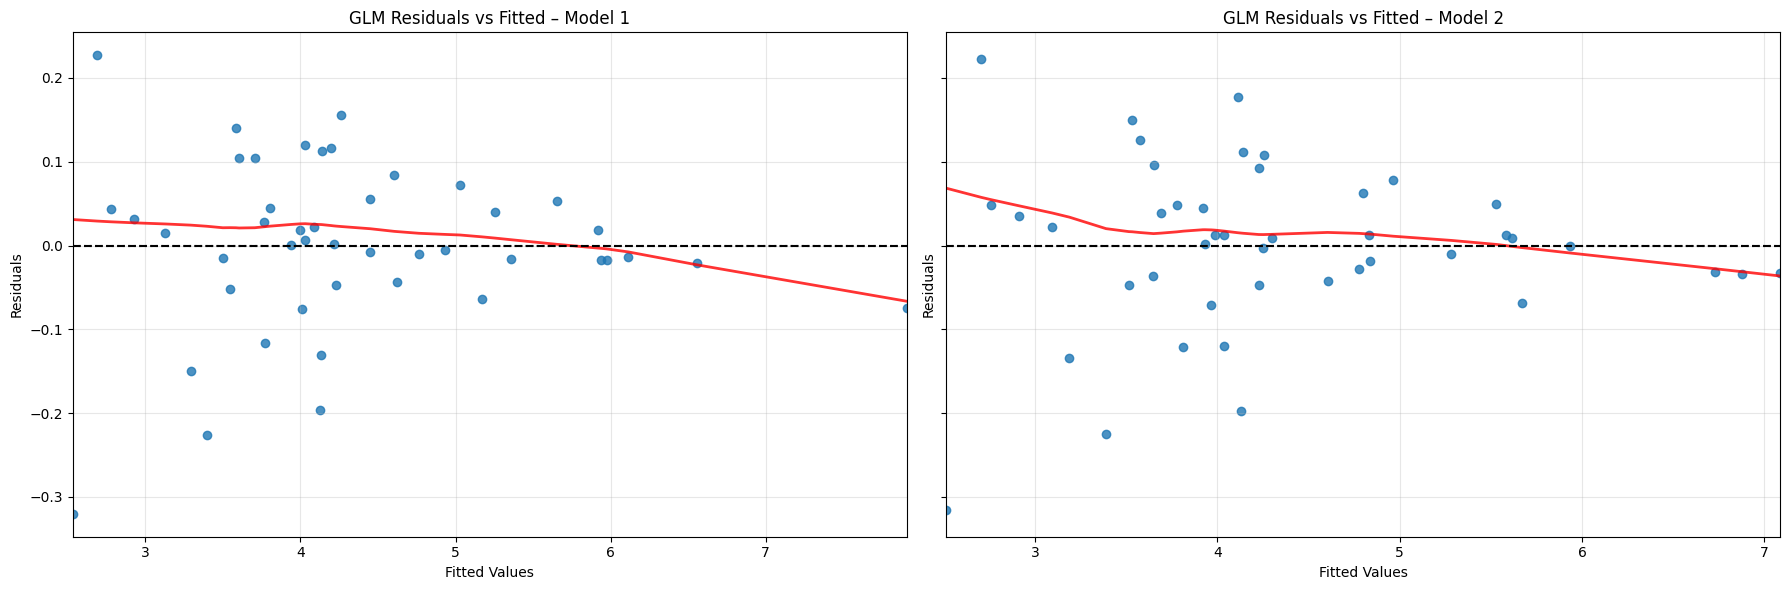

In [423]:
res_vs_fitted_glm_double(glm_log_economy, glm_log_luxury)

Good enough, no need to do spline or something.
Current transformation is "good enough" structurally. The remaining "wiggles" in the red line are likely noise, not a structural trend that a Spline would fix better than the current setup

In [424]:
# Homoscedasticity tests

_, pval, __, ___ = het_breuschpagan(glm_log_economy.resid_deviance, glm_log_economy.model.exog)
print(f"Breusch-Pagan p-value - economy airbnb: {pval}")

_, pval, __, ___ = het_breuschpagan(glm_log_luxury.resid_deviance, glm_log_luxury.model.exog)
print(f"Breusch-Pagan p-value - luxury airbnb: {pval}")

Breusch-Pagan p-value - economy airbnb: 0.05574756585010101
Breusch-Pagan p-value - luxury airbnb: 0.06193469077594191


The Breusch–Pagan test shows marginal evidence of heteroscedasticity. While slightly below conventional thresholds, the residuals do not strongly violate the homoscedasticity assumption, so the model can be considered acceptable for further analysis.

## Multicollinearity and Feature Selection

#### Correlation Matrix

In [425]:
features_economy = ['dist_center_km', 'airbnb_economy_density', 'tourist_density', 
            'crime_attractor_density', 'crime_generator_density', 
            'foreigner_density', 'university_density', 'unemployment', 'mhd_density']

corr_matrix_economy = X_no_outliers_e[features_economy].corr()

features_luxury = ['dist_center_km', 'airbnb_luxury_density', 'tourist_density', 
            'crime_attractor_density', 'crime_generator_density', 
            'foreigner_density', 'university_density', 'unemployment', 'mhd_density']

corr_matrix_luxury = X_no_outliers_l[features_luxury].corr()

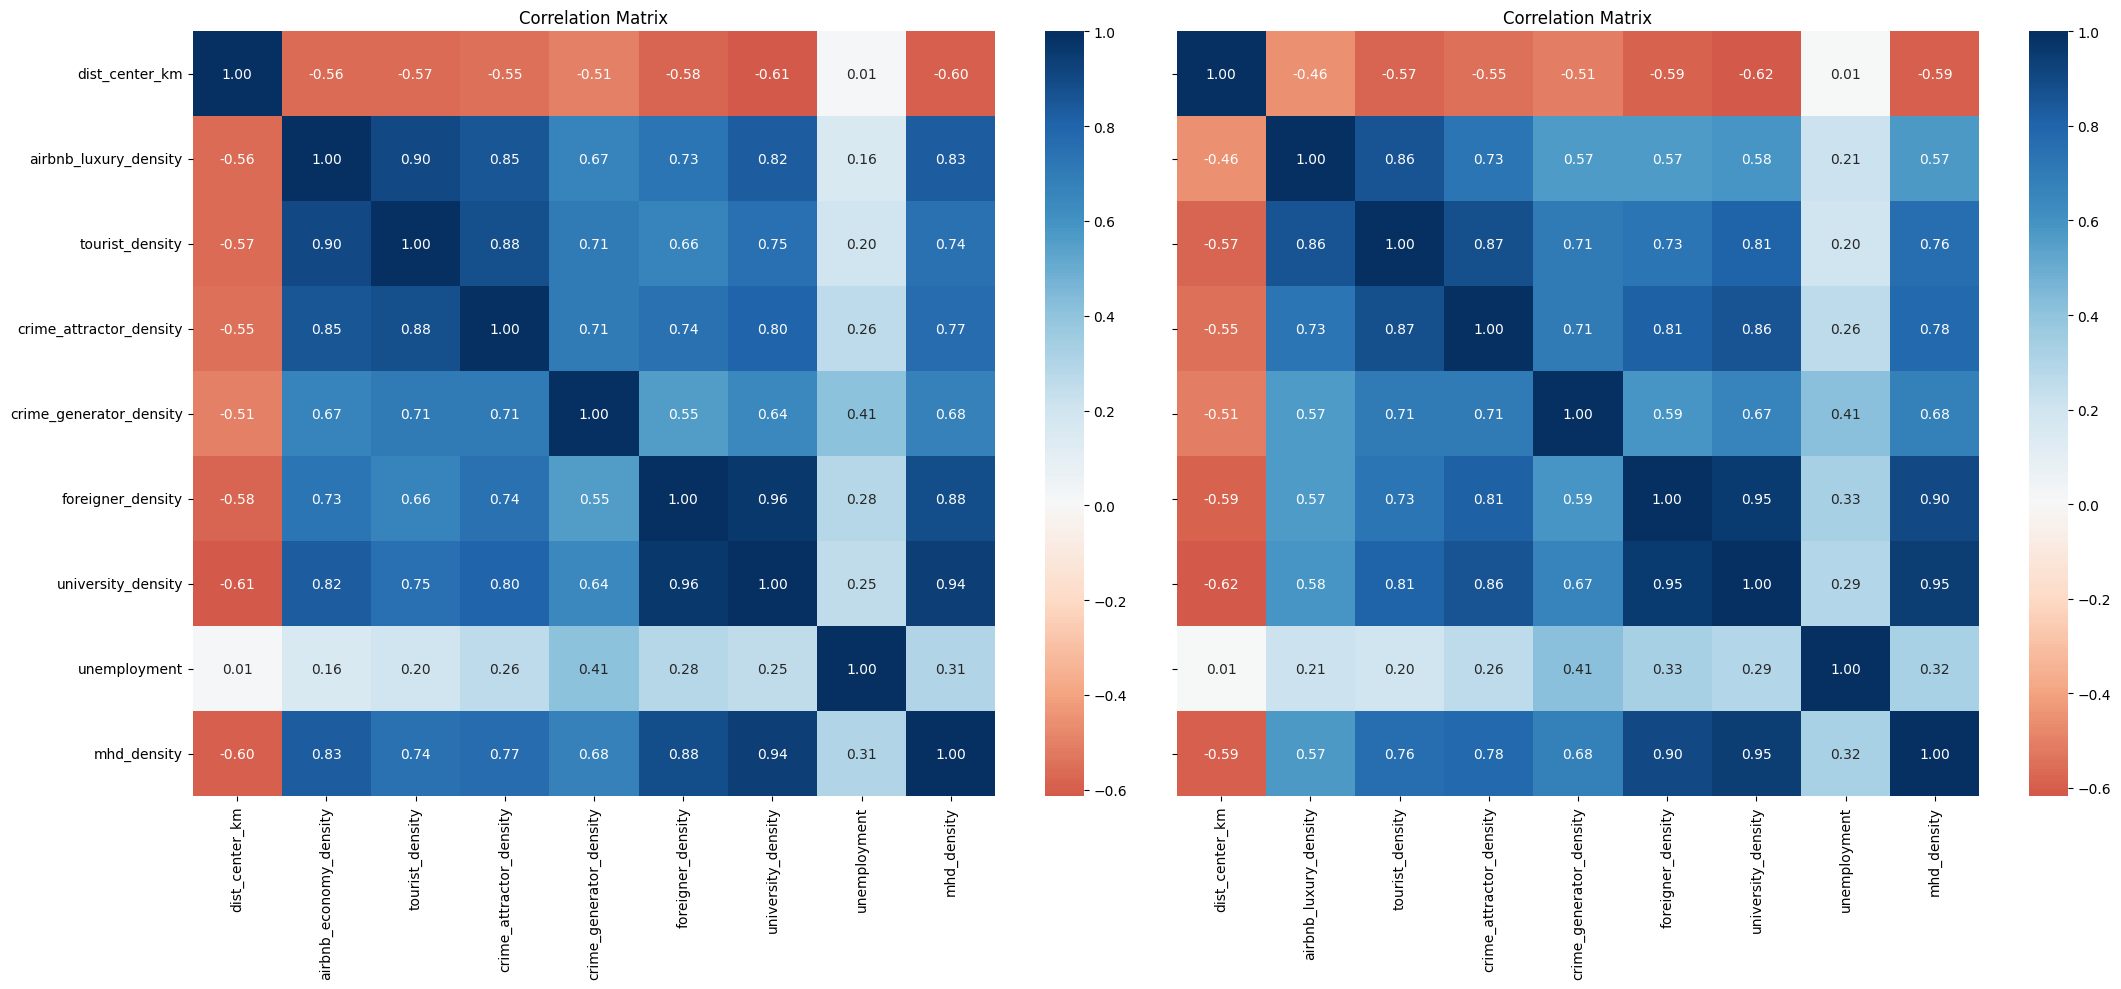

In [426]:
def corr_mtx_plt(corr_matrix_1, corr_matrix_2):

    def _corr_mtx_plt(corr_matrix, _ax=0):
        sns.heatmap(
            corr_matrix,
            annot=True,
            cmap='RdBu',
            center=0,
            fmt=".2f",
            ax=axes[_ax]
        )
        axes[_ax].set_title("Correlation Matrix")

    _, axes = plt.subplots(1, 2, figsize=(22, 10), sharey=True)

    _corr_mtx_plt(corr_matrix_1, _ax=0)
    _corr_mtx_plt(corr_matrix_2, _ax=1)

    plt.tight_layout()
    plt.show()

corr_mtx_plt(corr_matrix_economy, corr_matrix_luxury)

For a value n of the correlation matrix:
- 0.1 ≤ n < 0.3 → weak positive correlation
- 0.3 ≤ n < 0.5 → moderate positive correlation
- n ≥ 0.5 → strong positive correlation
- –0.3 < n ≤ –0.1 → weak negative correlation
- –0.5 < n ≤ –0.3 → moderate negative correlation
- n ≤ –0.5 → strong negative correlation

Except the variable 'unemployment', which correlates weakly with every other variable, the rest shows strong positive or negative correlation.
Thus, feature selection is critical. There are no significant differences between the matrices of the economy and luxury airbnb.

#### VIF Factor

In [427]:
# economy
X_vif_economy = X_no_outliers_e[features_economy].copy()
X_vif_economy['intercept'] = 1

vif_data_economy = pd.DataFrame()
vif_data_economy["feature"] = X_vif_economy.columns
vif_data_economy["VIF"] = [variance_inflation_factor(X_vif_economy.values, i) for i in range(len(X_vif_economy.columns))]

# luxury
X_vif_luxury = X_no_outliers_l[features_luxury].copy()
X_vif_luxury['intercept'] = 1

vif_data_luxury = pd.DataFrame()
vif_data_luxury["feature"] = X_vif_luxury.columns
vif_data_luxury["VIF"] = [variance_inflation_factor(X_vif_luxury.values, i) for i in range(len(X_vif_luxury.columns))]


In [428]:
print("\nEconomy Airbnb VIFs:\n")
print(vif_data_economy.sort_values(by="VIF", ascending=False))

print("\nLuxury Airbnb VIFs:\n")
print(vif_data_luxury.sort_values(by="VIF", ascending=False))


Economy Airbnb VIFs:

                   feature        VIF
9                intercept  39.329337
6       university_density  28.996173
5        foreigner_density  15.117340
8              mhd_density  10.214547
1   airbnb_economy_density   8.308187
2          tourist_density   7.716321
3  crime_attractor_density   5.790172
4  crime_generator_density   2.875791
0           dist_center_km   1.914470
7             unemployment   1.569770

Luxury Airbnb VIFs:

                   feature        VIF
9                intercept  38.772322
6       university_density  38.681807
5        foreigner_density  15.424207
2          tourist_density  12.916764
8              mhd_density  11.956914
3  crime_attractor_density   6.888568
1    airbnb_luxury_density   5.887529
4  crime_generator_density   2.996390
0           dist_center_km   1.907548
7             unemployment   1.558655


For a VIF value n:
- ≈ 1 → no multicollinearity
- 1 – 2 → very low
- 2 – 5 → moderate (still acceptable)
- 5 – 10 → high (needs examination)
- \> 10 → severe

The VIF analysis indicates that unemployment, consistent with the correlation matrix results, dist_center_km, and crime_generator_density have acceptable multicollinearity levels, however, according to the correlation matrix they are already in the grey zone. The remaining variables exhibit high VIF values, suggesting problematic multicollinearity. Therefore, feature selection is employed in the next step to address this issue.

### Removing multicollinearity

##### Stepwise Dropping Features

In [429]:
def stepwise_feature_selection(df, list_of_features, threshold=5.0):
    """
    Automatically drops the variable with the highest VIF 
    until all remaining variables are below the threshold.
    """
    while True:

        X = df[list_of_features].copy()
        X['intercept'] = 1
        
        vif = pd.DataFrame()
        vif["feature"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
        vif = vif[vif['feature'] != 'intercept'].sort_values('VIF', ascending=False)
        
        max_vif = vif.iloc[0]['VIF']
        if max_vif > threshold:
            if vif.iloc[0]['feature'] == 'airbnb_economy_density':
                target = vif.iloc[1]['feature']
            else:
                target = vif.iloc[0]['feature']
                
            print(f"Dropping {target} with VIF {max_vif:.2f}")
            list_of_features.remove(target)
        else:
            break
            
    return list_of_features, vif


In [430]:
_features_economy = features_economy.copy()
_features_luxury = features_luxury.copy()

final_features_economy, final_vif_table_economy = stepwise_feature_selection(X_no_outliers_e, _features_economy)
print("\nFinal VIF Table:\n", final_vif_table_economy)
print()

final_features_luxury, final_vif_table_luxury = stepwise_feature_selection(X_no_outliers_l, _features_luxury)
print("\nFinal VIF Table:\n", final_vif_table_luxury)

Dropping university_density with VIF 29.00
Dropping tourist_density with VIF 8.18
Dropping mhd_density with VIF 7.38

Final VIF Table:
                    feature       VIF
2  crime_attractor_density  4.563369
1   airbnb_economy_density  4.289009
4        foreigner_density  2.840978
3  crime_generator_density  2.594595
0           dist_center_km  1.846605
5             unemployment  1.452514

Dropping university_density with VIF 38.68
Dropping tourist_density with VIF 9.99
Dropping foreigner_density with VIF 7.43

Final VIF Table:
                    feature       VIF
2  crime_attractor_density  4.040519
5              mhd_density  3.181543
3  crime_generator_density  2.535614
1    airbnb_luxury_density  2.169733
0           dist_center_km  1.809046
4             unemployment  1.362070


##### Ridge Regression

- Predictors are measured in different units and scales

- Ridge and Lasso apply a penalty based on coefficient magnitude

- Without standardization, variables with large numeric scales are penalized more heavily, regardless of their true importance

- Standardization ensures that the regularization penalty is applied equally across predictors, making coefficient shrinkage comparable and meaningful

In [431]:
from sklearn.preprocessing import StandardScaler

def scale_data(data, features):
    X = data[features]
    y = np.log1p(data['crime_density'])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

X_scaled_econ, y_econ = scale_data(X_no_outliers_e, features_economy)
X_scaled_lux, y_lux = scale_data(X_no_outliers_l, features_luxury)

In [432]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV

ridge_model_econ = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_model_econ.fit(X_scaled_econ, y_econ)

# Create a summary of coefficients
ridge_coefs = pd.Series(ridge_model_econ.coef_, index=features_economy).sort_values(ascending=False)
print("Best Alpha for Ridge:", ridge_model_econ.alpha_)
print("\nRidge Coefficients:\n", ridge_coefs)
print()

#-------------------------------------------------------------------------------------------------

ridge_model_lux = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_model_lux.fit(X_scaled_lux, y_lux)

# Create a summary of coefficients
ridge_coefs = pd.Series(ridge_model_lux.coef_, index=features_luxury).sort_values(ascending=False)
print("Best Alpha for Ridge:", ridge_model_lux.alpha_)
print("\nRidge Coefficients:\n", ridge_coefs)

Best Alpha for Ridge: 10.0

Ridge Coefficients:
 mhd_density                0.398129
foreigner_density          0.278292
university_density         0.170431
crime_generator_density    0.093354
tourist_density            0.021648
airbnb_economy_density    -0.036121
unemployment              -0.082223
crime_attractor_density   -0.110451
dist_center_km            -0.212648
dtype: float64

Best Alpha for Ridge: 10.0

Ridge Coefficients:
 mhd_density                0.372511
foreigner_density          0.303104
university_density         0.187575
crime_generator_density    0.092672
airbnb_luxury_density      0.055378
tourist_density           -0.036060
unemployment              -0.092077
crime_attractor_density   -0.151615
dist_center_km            -0.205508
dtype: float64


The Ridge results indicate that structural urban factors like MHD (transit) density, foreigner density, and proximity to the center are the primary drivers of crime in Prague, regardless of the rental type. In both models, high transit accessibility emerged as the strongest predictor, suggesting that crime is most concentrated around major transportation hubs. Interestingly, the model chose a high penalty (Alpha 10.0), which stabilized the coefficients and successfully mitigated the extreme multicollinearity that previously skewed your results.

The most critical finding lies in the divergence between the two segments: Luxury Airbnbs show a positive association with crime density (+0.055), while Economy Airbnbs show a slight negative association (-0.036). This suggests that luxury rentals are more closely tied to high-crime areas or are better proxies for the specific urban environments where crime occurs. Because these coefficients are relatively small compared to transit density, running a Lasso regression is the logical next step to see if the Luxury Airbnb effect is mathematically robust enough to be kept in the model or if it will be zeroed out as noise.

##### Lasso Regression

In [433]:
lasso_model_econ = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_model_econ.fit(X_scaled_econ, y_econ)

lasso_coefs_econ = pd.Series(lasso_model_econ.coef_, index=features_economy).sort_values(ascending=False)
print("Best Alpha for Lasso:", lasso_model_econ.alpha_)
print("\nLasso Coefficients (Variables at 0 are excluded):\n", lasso_coefs_econ)

lasso_model_lux = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_model_lux.fit(X_scaled_lux, y_lux)

lasso_coefs_lux = pd.Series(lasso_model_lux.coef_, index=features_luxury).sort_values(ascending=False)
print("Best Alpha for Lasso:", lasso_model_lux.alpha_)
print("\nLasso Coefficients (Variables at 0 are excluded):\n", lasso_coefs_lux)

Best Alpha for Lasso: 0.029264922188299097

Lasso Coefficients (Variables at 0 are excluded):
 mhd_density                0.693389
foreigner_density          0.280638
crime_generator_density    0.019460
university_density         0.000000
tourist_density            0.000000
airbnb_economy_density    -0.042550
unemployment              -0.080131
crime_attractor_density   -0.124262
dist_center_km            -0.217733
dtype: float64
Best Alpha for Lasso: 0.009488285797538703

Lasso Coefficients (Variables at 0 are excluded):
 mhd_density                0.613100
foreigner_density          0.526884
crime_generator_density    0.140316
airbnb_luxury_density      0.099746
university_density        -0.000000
tourist_density           -0.047315
unemployment              -0.160296
dist_center_km            -0.192756
crime_attractor_density   -0.417810
dtype: float64


/home/teruna/Documents/cvut_fel/engineer/san/_semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
/home/teruna/Documents/cvut_fel/engineer/san/_semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


The Lasso results provide the ultimate "feature selection" by mathematically zeroing out the variables that do not contribute unique explanatory power. In both models, MHD density and foreigner density remain the most dominant predictors, with transit accessibility seeing its influence nearly double compared to the Ridge model. Notably, Lasso has completely eliminated university density and tourist_density in the economy model (setting them to 0.000), effectively deciding that these variables were redundant "noise" once transit and foreigner populations were accounted for.

The comparison between rental segments is now even sharper: Luxury Airbnbs survived the "zeroing" process with a positive coefficient of approximately 0.10, confirming that luxury rentals have a robust, non-zero association with higher crime density. Conversely, Economy Airbnbs retained a small negative coefficient (-0.04), suggesting they play a much smaller and fundamentally different role in the urban landscape. Essentially, the Lasso model suggests that while general tourism might be redundant, the specific presence of luxury short-term rentals provides a unique signal for crime density that other variables cannot capture.

No significant difference between economy and luxury airbnb density in the areas was proven.

## Dimensionality Reduction and Clustering

Since the estimated coefficients and overall model behavior of the economy and luxury specifications are largely analogous, principal component analysis is conducted exclusively for the economy model.

PC1 explains 68.66% of the variance.
PC2 explains 11.87% of the variance.


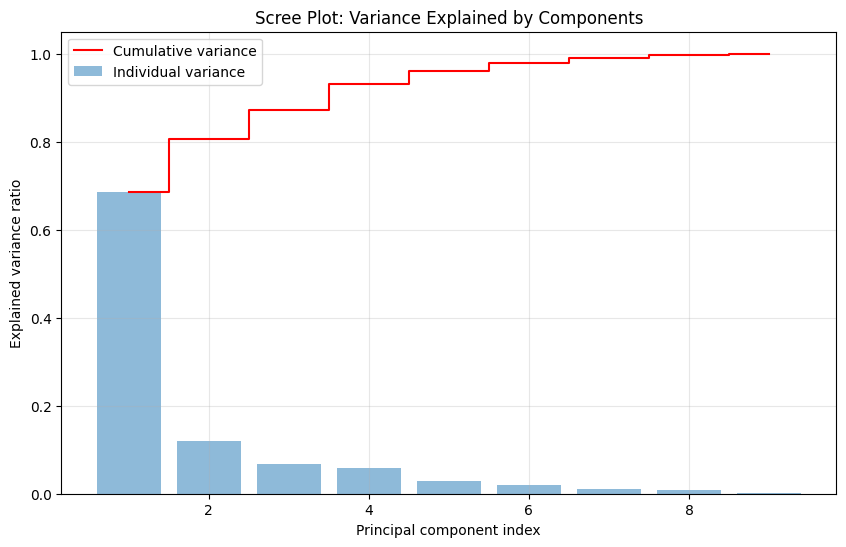

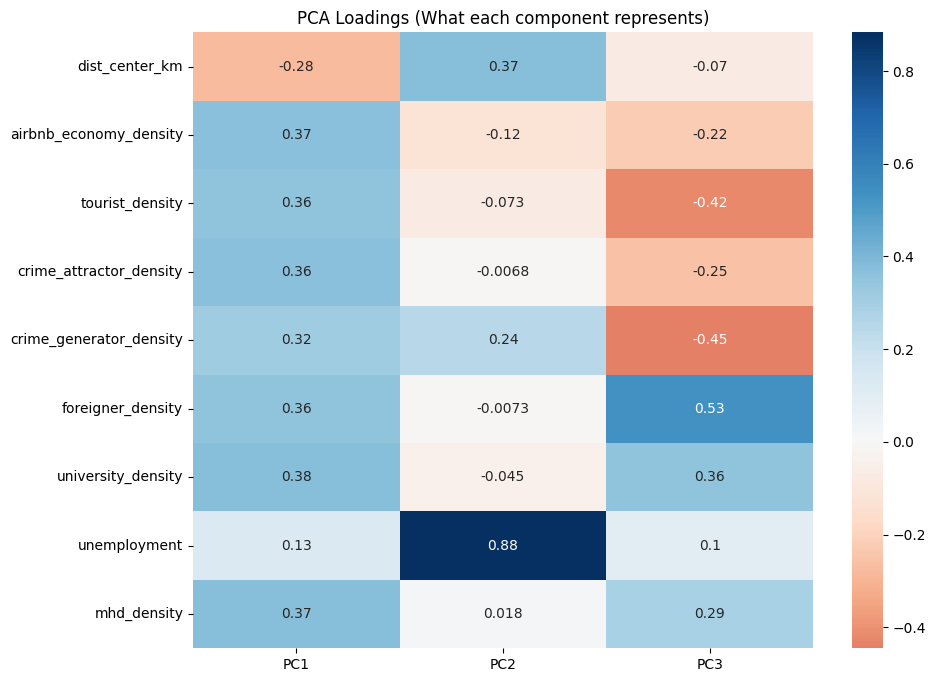

In [434]:
from sklearn.decomposition import PCA

pca = PCA()
pca_features = pca.fit_transform(X_scaled_econ)

# 4. Visualization: The Scree Plot (Explained Variance)
exp_var_cum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(exp_var_cum) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual variance')
plt.step(range(1, len(exp_var_cum) + 1), exp_var_cum, where='mid', label='Cumulative variance', color='red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Scree Plot: Variance Explained by Components')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.savefig('pca_scree_plot.png')

# 5. Interpretation: Component Loadings
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(len(features_economy))], 
    index=features_economy
)

plt.figure(figsize=(10, 8))
sns.heatmap(loadings.iloc[:, :3], annot=True, cmap='RdBu', center=0)
plt.title('PCA Loadings (What each component represents)')
plt.savefig('pca_loadings_heatmap.png')

# 6. Add the Top Components back to your DataFrame for the GLM
# Usually, PC1 and PC2 are enough
X_no_outliers_e['Urban_Intensity_PC1'] = pca_features[:, 0]
X_no_outliers_e['Social_Structure_PC2'] = pca_features[:, 1]

print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the variance.")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of the variance.")

1. The Scree Plot (Top Graph)

This graph tells you how many components you need to keep to represent your original data accurately.

- Individual Variance (Blue Bars): The first bar shows that PC1 alone captures nearly 70% of all the information (variance) from your 9 original variables. The bars drop off quickly, meaning most of the "story" is in the first few components.

- Cumulative Variance (Red Line): This shows the "running total." By the time you get to PC3, the red line is above 0.9, meaning you have captured over 90% of the original data's information using only 3 variables instead of 9.

- The "Elbow": Notice the sharp bend at PC2. This suggests that using just 2 or 3 components is the "sweet spot" for your model.

2. The PCA Loadings Heatmap (Bottom Graph)

This heatmap explains what your new components (PC1, PC2, PC3) actually mean in real-world terms by showing how they relate to your original variables.

- PC1: "Urban Core / Tourism Intensity" Almost all variables have high positive scores (around 0.32 to 0.38) except for distance from center, which is negative (-0.28). This means PC1 represents the typical "busy" parts of Prague: high Airbnb density, lots of tourists, transit (MHD), and universities, all located close to the center.

- PC2: "Socio-Economic / Residential Factor" This component is dominated by Unemployment (0.88) and Distance (0.37). If a district has a high PC2 score, it is likely a residential area further from the center with higher unemployment, independent of the tourist "noise."

- PC3: "The Foreigner/Generator Mix" This shows a strong positive link to Foreigner Density (0.53) but a strong negative link to Crime Generators (-0.45) and Tourist Density (-0.42). It captures unique neighborhoods that have many foreign residents but aren't necessarily tourist "crime hotspots."

## Conclusion

The results of correlation matrices, VIF factors, Lasso and Ridge regressions and PCA are consistent.

# Influence Of Airbnbs On Particular Crime Type

#### Add other columns

Adding density columns for 'crime_Burglary', 'crime_Disorder', 'crime_Other', 'crime_Theft', 'crime_Violent'.

In [435]:
df['crime_Burglary_density'] = df['crime_Burglary'] / df['area_km2']
df['crime_Disorder_density'] = df['crime_Disorder'] / df['area_km2']
df['crime_Theft_density'] = df['crime_Theft'] / df['area_km2']
df['crime_Violent_density'] = df['crime_Violent'] / df['area_km2']
df['crime_Other_density'] = df['crime_Other'] / df['area_km2']

df.fillna(0.0)
df.columns
df

,district_name,population,area_km2,dist_center_km,crime_total,crime_rate,crime_Burglary,crime_Disorder,crime_Other,crime_Theft,...,crime_generator_density,tourist_density,foreigner_density,university_density,airbnb_economy_density,crime_Burglary_density,crime_Disorder_density,crime_Theft_density,crime_Violent_density,crime_Other_density
0,Praha 1,28921,5.538429,0.362492,14712,508.696103,336,1085,11335,1781,...,84.681053,1.268182e+06,1494.467104,1454.744649,70.055967,60.667023,195.903928,321.571332,31.597408,2046.609234
1,Praha 10,119110,18.599771,5.767105,10055,84.417765,631,518,7949,896,...,3.279610,2.815895e+04,1529.857569,1747.655953,5.698995,33.925149,27.849806,48.172637,3.279610,427.370860
2,Praha 11,78410,9.793681,8.809829,9581,122.191047,203,233,8694,421,...,1.327387,3.081058e+04,1784.824402,1670.567050,0.918960,20.727652,23.790852,42.986904,3.063200,887.715295
3,Praha 12,59999,23.317910,10.580188,3158,52.634211,156,209,2557,197,...,0.686168,0.000000e+00,480.446152,576.123682,0.514626,6.690137,8.963068,8.448442,1.672534,109.658200
4,Praha 13,66604,13.196803,8.592411,3932,59.035493,129,263,3269,231,...,0.833535,2.231525e+03,1441.864366,1304.179504,1.591294,9.775095,19.929069,17.504239,3.031037,247.711510
5,Praha 14,50525,13.529637,9.888782,4205,83.226126,202,284,3334,347,...,0.739118,1.135212e+03,1029.443736,735.644278,0.665206,14.930186,20.990955,25.647399,2.808649,246.421986
6,Praha 15,35991,10.255992,9.352180,3879,107.776944,141,104,3425,200,...,0.682528,3.302557e+03,724.747051,830.246353,0.390016,13.748061,10.140413,19.500795,0.877536,333.951117
7,Praha 16,8766,9.298437,11.863836,677,77.230208,21,43,562,38,...,0.322635,0.000000e+00,138.195273,204.658059,0.215090,2.258444,4.624433,4.086708,1.398084,60.440267
8,Praha 17,24065,3.253142,8.184499,1214,50.446707,29,110,970,75,...,2.151766,0.000000e+00,1340.242553,1558.493060,1.229580,8.914457,33.813459,23.054631,9.221852,298.173228
9,Praha 18,23728,5.606560,8.778075,1705,71.856035,32,194,1356,113,...,0.356725,1.675537e+03,1331.654404,949.066848,0.535087,5.707600,34.602324,20.154962,1.783625,241.859546


#### Simple OLS Models

We compute with general airbnb_density, where we do not distinguish between economy and luxury as far as no big differences between them was proven.

In [436]:
lm_burglary = smf.ols('crime_Burglary_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_disorder = smf.ols('crime_Disorder_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_theft = smf.ols('crime_Theft_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_violent = smf.ols('crime_Violent_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_other = smf.ols('crime_Other_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

## Outliers

#### Analysing Outliers

In [437]:
# outliers detection using Cook's distance
outliers_burglary, cooks_d_burglary = detect_outliers(lm_burglary)
print(f"Outliers of economy model: {outliers_burglary}")

outliers_disorder, cooks_d_disorder = detect_outliers(lm_disorder)
print(f"Outliers of luxury model: {outliers_disorder}")

outliers_theft, cooks_d_theft = detect_outliers(lm_theft)
print(f"Outliers of luxury model: {outliers_theft}")

outliers_violent, cooks_d_violent = detect_outliers(lm_violent)
print(f"Outliers of luxury model: {outliers_violent}")

outliers_other, cooks_d_other = detect_outliers(lm_other)
print(f"Outliers of luxury model: {outliers_other}")

Outliers of economy model: [ 0  1  8 11 15 16 19 46]
Outliers of luxury model: [ 0  8  9 15 19 46]
Outliers of luxury model: [ 0  1  2  8 11 15 18 19 46 56]
Outliers of luxury model: [ 0  1  8 11 15 18 19 46]
Outliers of luxury model: [ 0  2  8 11 15 19 21 41 46]


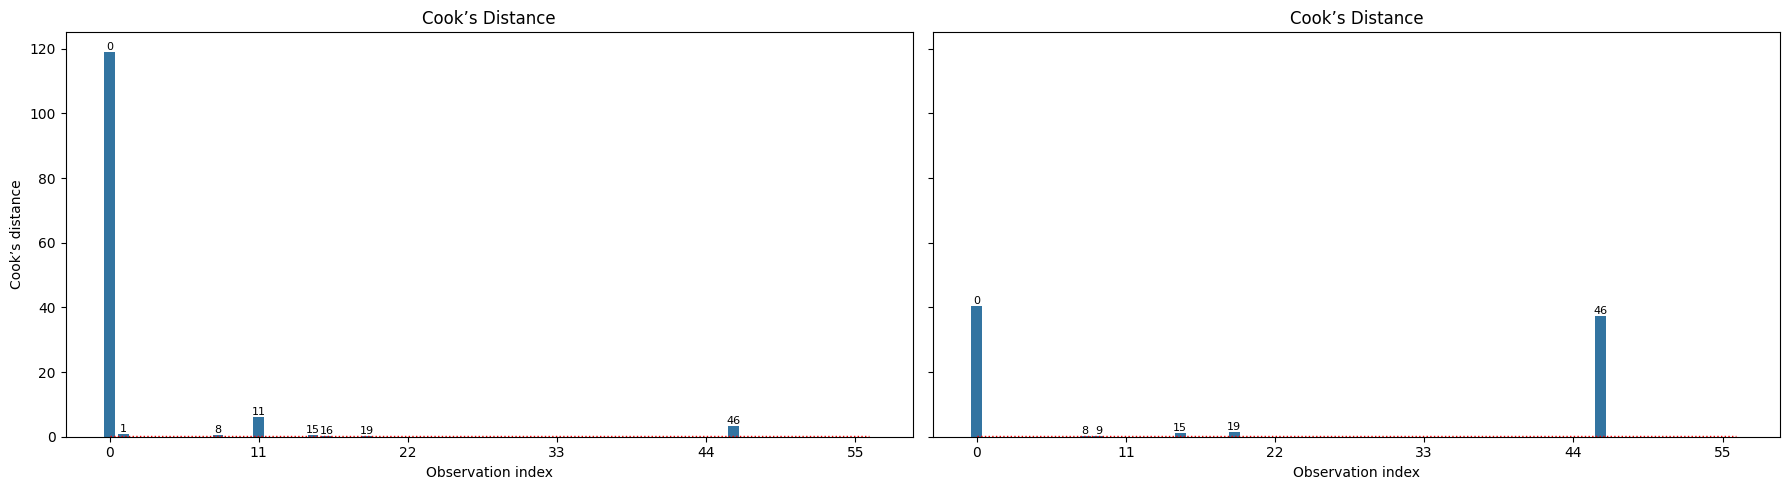

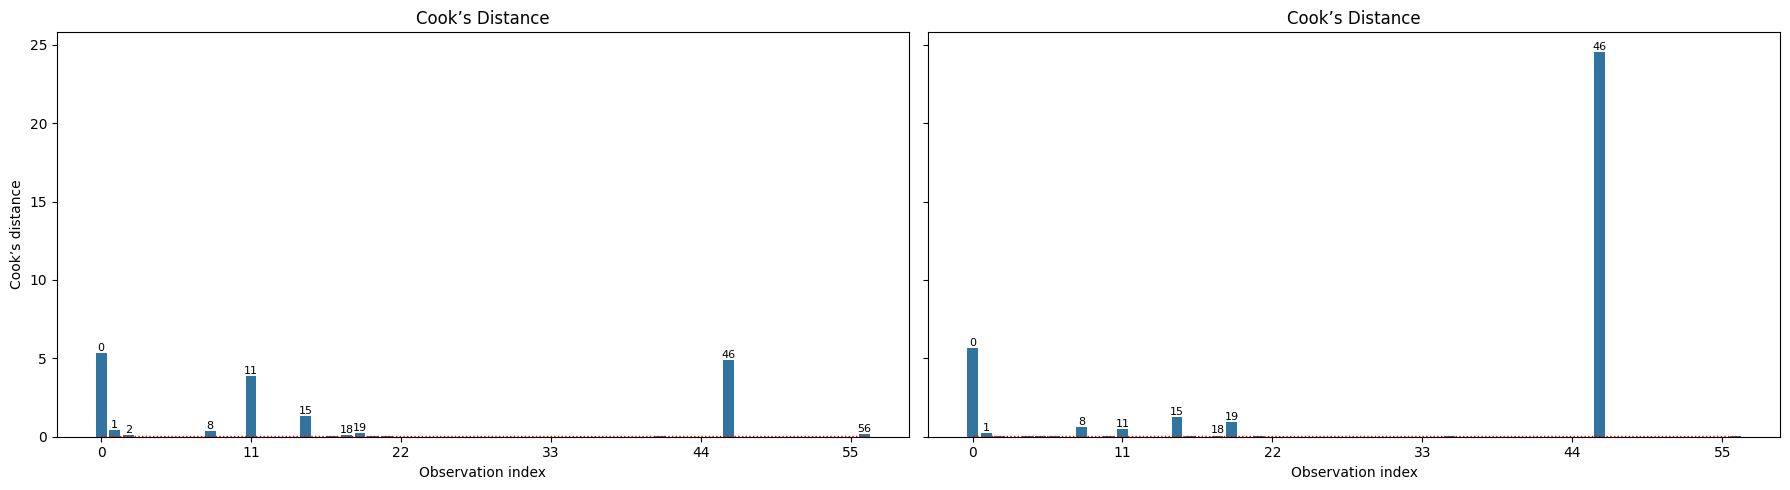

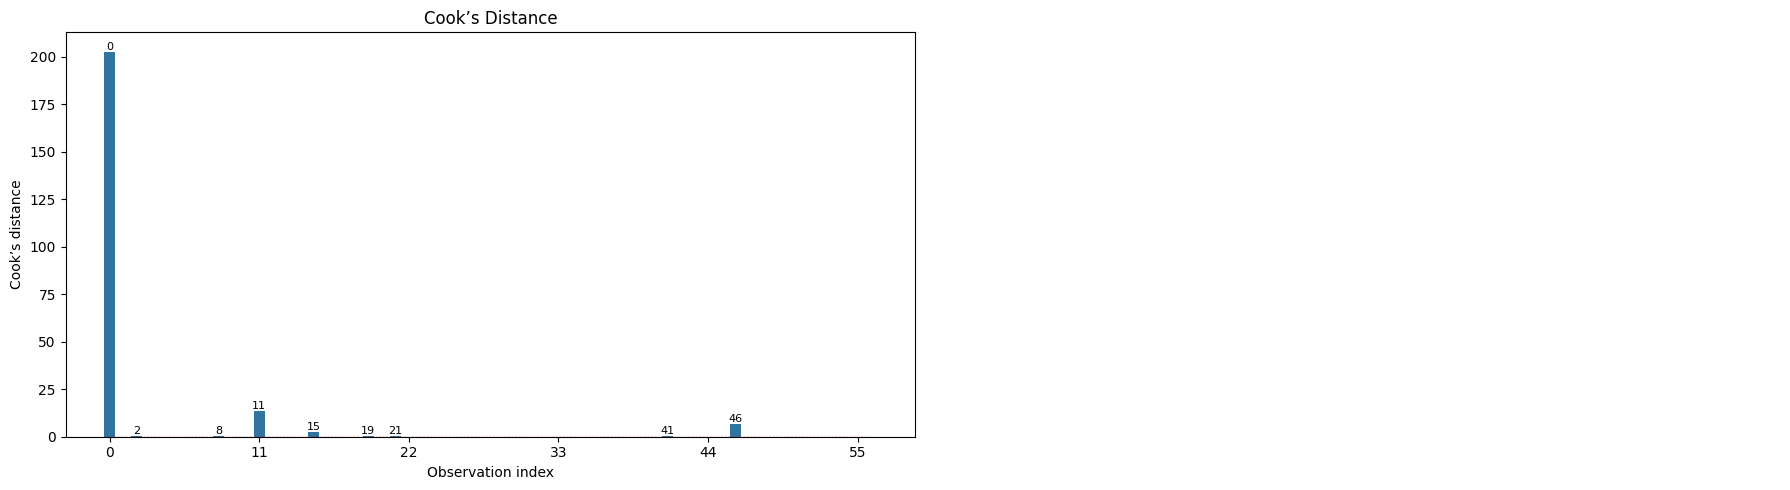

In [438]:
outliers_double_plot(cooks_d_burglary, cooks_d_disorder, outliers_burglary, outliers_disorder)
outliers_double_plot(cooks_d_theft, cooks_d_violent, outliers_theft, outliers_violent)
outlier_single_plot(cooks_d_other, outliers_other)

#### Remove outliers

In [439]:
X_bulglary = df.drop(outliers_burglary)
X_disorder = df.drop(outliers_disorder)
X_theft = df.drop(outliers_theft)
X_violent = df.drop(outliers_violent)
X_other = df.drop(outliers_other)

## Linearity and Homoscedasticity

#### Create simple OLS models without outliers

In [ ]:
lm_burglary = smf.ols('crime_Burglary_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_bulglary).fit()

lm_disorder = smf.ols('crime_Disorder_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_disorder).fit()

lm_theft = smf.ols('crime_Theft_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_theft).fit()

lm_violent = smf.ols('crime_Violent_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_violent).fit()

lm_other = smf.ols('crime_Other_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_other).fit()

#### Analysis of linearity and homoscedasticity quality

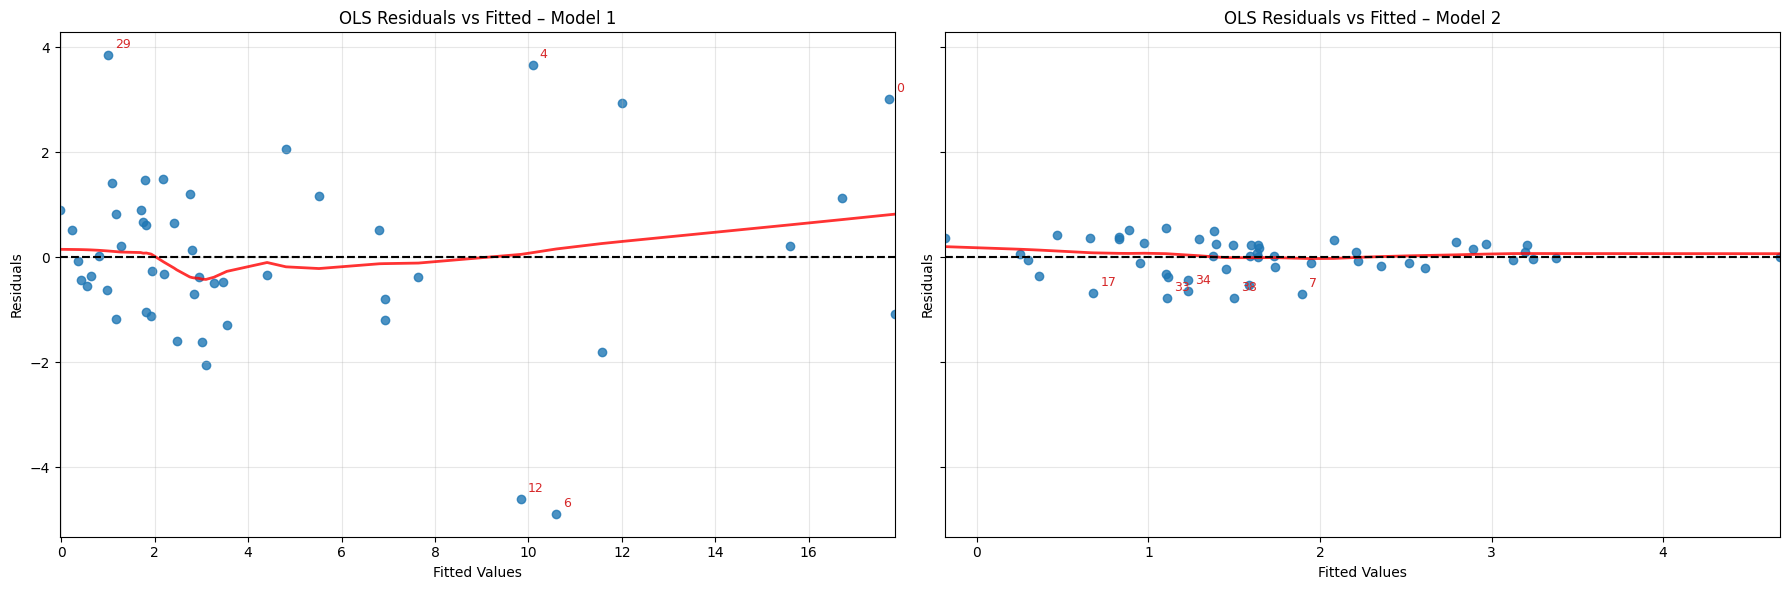

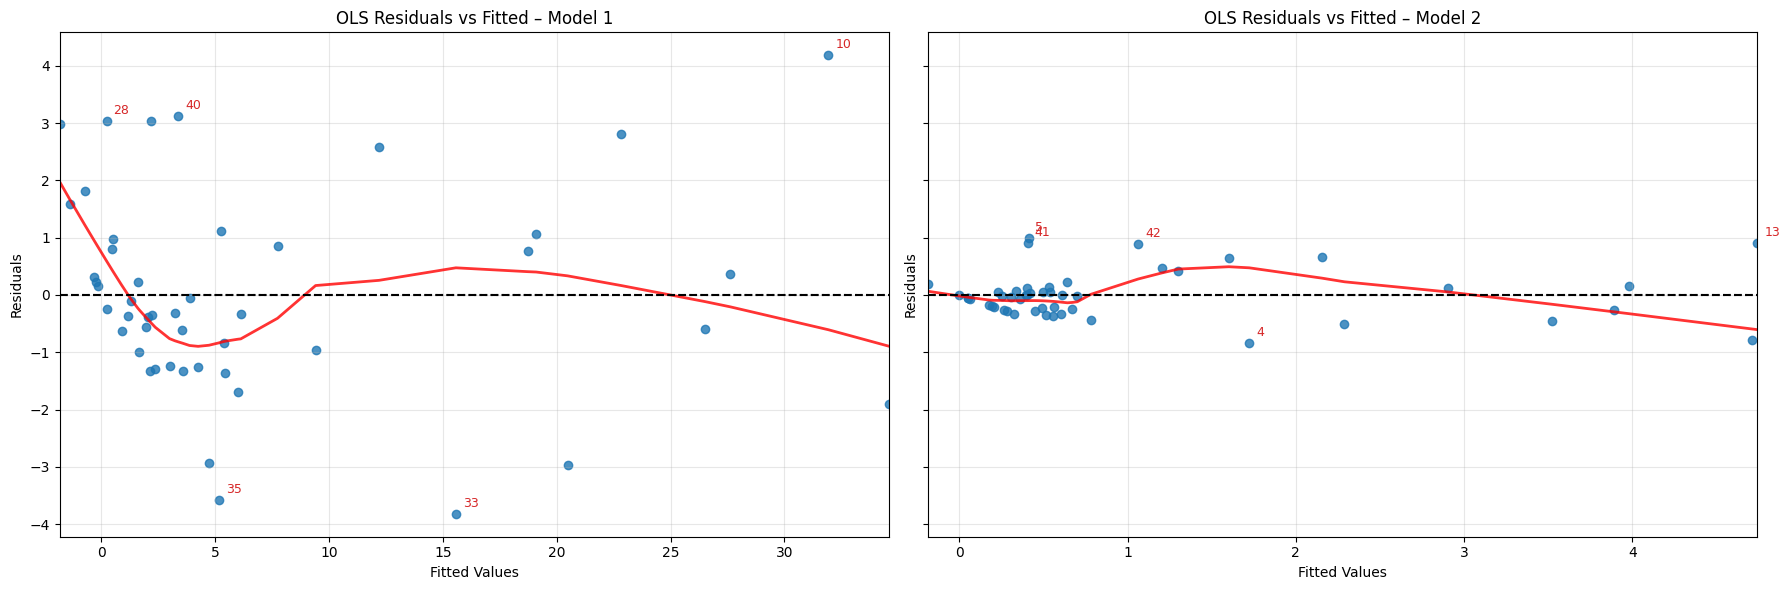

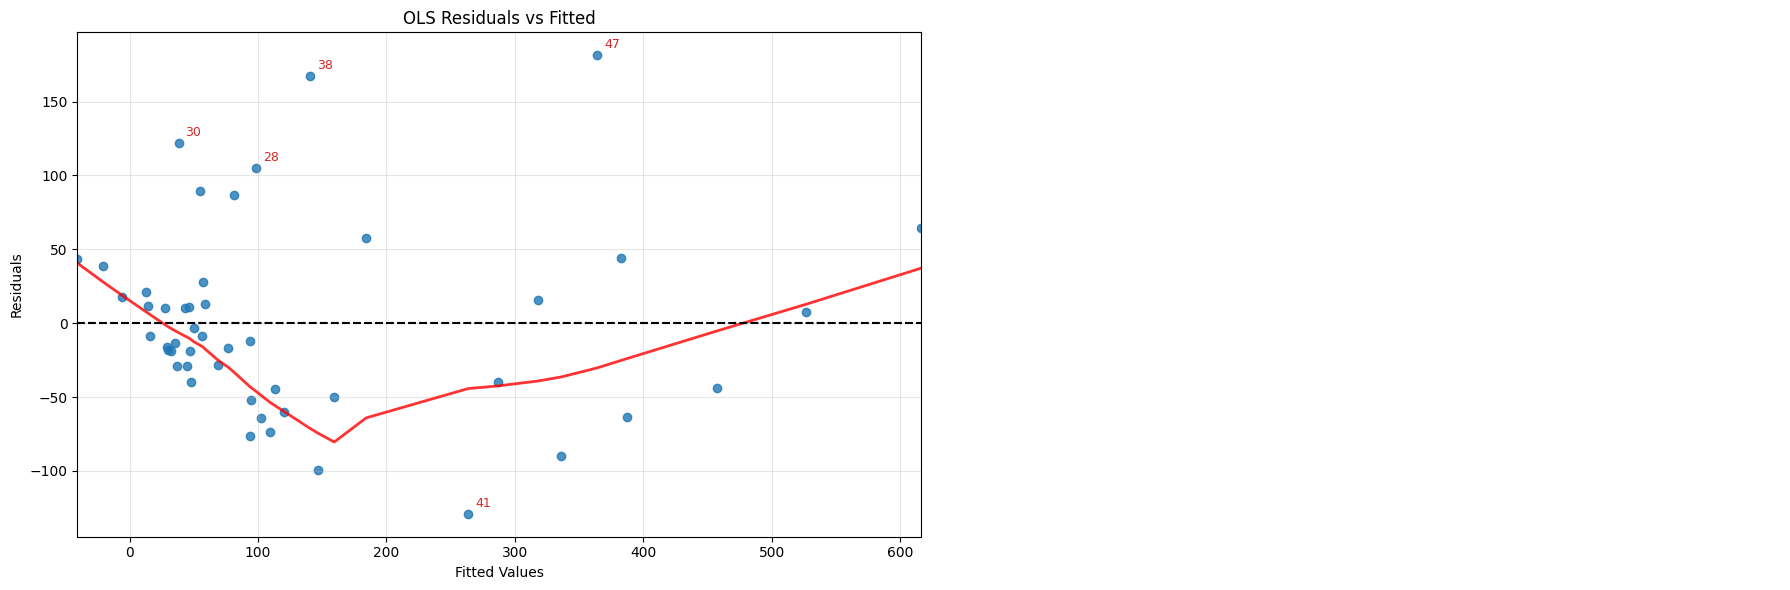

In [441]:
res_vs_fitted_ols_double(lm_burglary, lm_disorder)
res_vs_fitted_ols_double(lm_theft, lm_violent)
res_vs_fitted_ols_single(lm_other)

Remove more significant outliers

According to the residuals vs fitted plot the data are scewed and we need to switch to GLM models and do feature transformation.

In [443]:
formula_burglary = ('crime_Burglary_density ~ dist_center_km + airbnb_density + '
    'crime_attractor_density + crime_generator_density + tourist_density + '
    'foreigner_density + university_density + unemployment + mhd_density')

formula_disorder = ('np.log1p(crime_Disorder_density) ~ dist_center_km + I(dist_center_km**2) + np.log1p(airbnb_density) + '
    'np.log1p(crime_attractor_density) + np.log1p(crime_generator_density) + '
    'np.log1p(tourist_density) + np.log1p(foreigner_density) + '
    'np.log1p(university_density) + unemployment + np.log1p(mhd_density)'
)

formula_theft = ('crime_Theft_density ~ dist_center_km + airbnb_density + '
    'crime_attractor_density + crime_generator_density + tourist_density + '
    'foreigner_density + university_density + unemployment + mhd_density')
 
formula_violent = ('crime_Violent_density ~ dist_center_km + airbnb_density + '
    'crime_attractor_density + crime_generator_density + tourist_density + '
    'foreigner_density + university_density + unemployment + mhd_density')

formula_other = ('crime_Other_density ~ dist_center_km + airbnb_density + '
    'crime_attractor_density + crime_generator_density + tourist_density + '
    'foreigner_density + university_density + unemployment + mhd_density')

In [444]:
glm_burglary = smf.glm(
    formula=formula_burglary, 
    data=X_bulglary, 
    family=sm.families.Gaussian()
).fit()

glm_disorder = smf.glm(
    formula=formula_disorder, 
    data=X_disorder,
    family=sm.families.Gaussian()
).fit()

glm_theft = smf.glm(
    formula=formula_theft, 
    data=X_theft, 
    family=sm.families.Gaussian()
).fit()

glm_violent = smf.glm(
    formula=formula_violent, 
    data=X_violent, 
    family=sm.families.Gaussian()
).fit()

glm_other = smf.glm(
    formula=formula_other, 
    data=X_other,
    family=sm.families.Gaussian()
).fit()

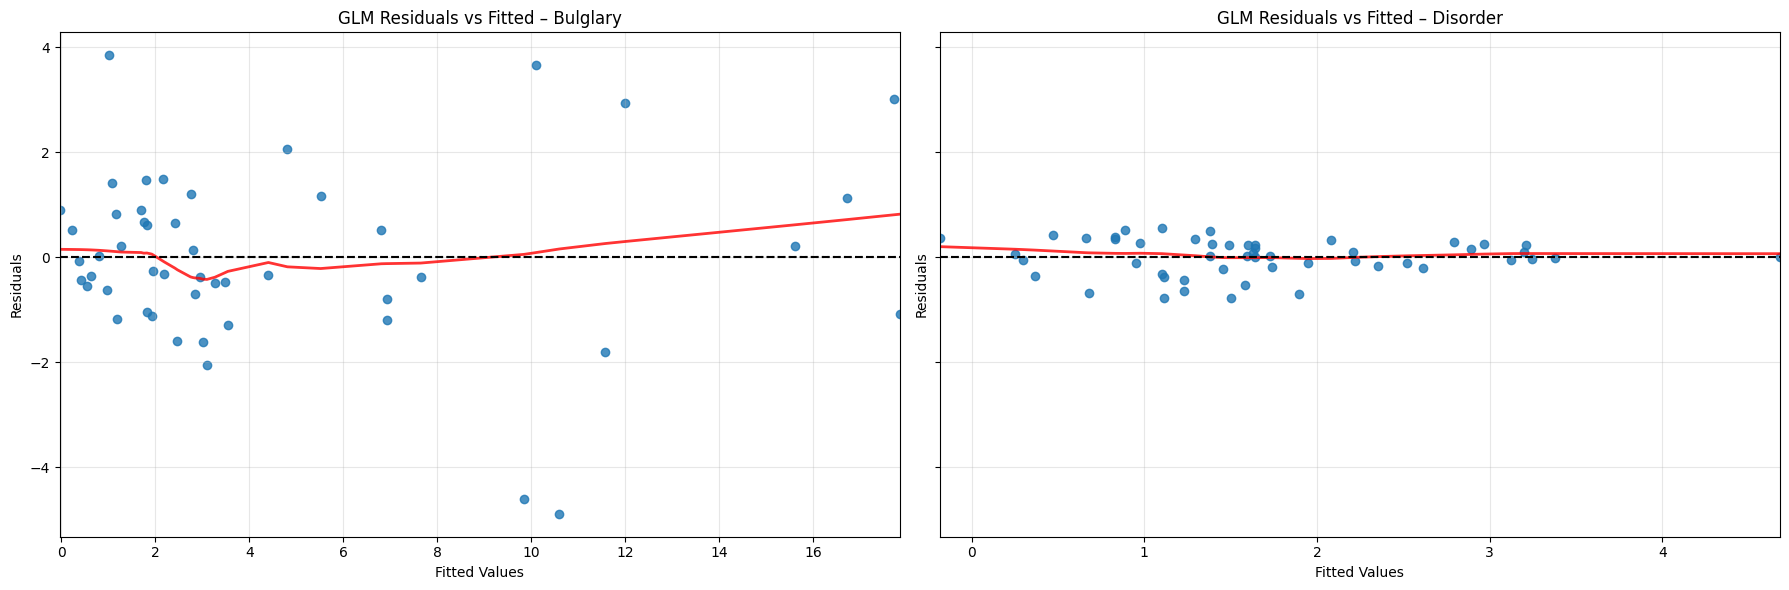

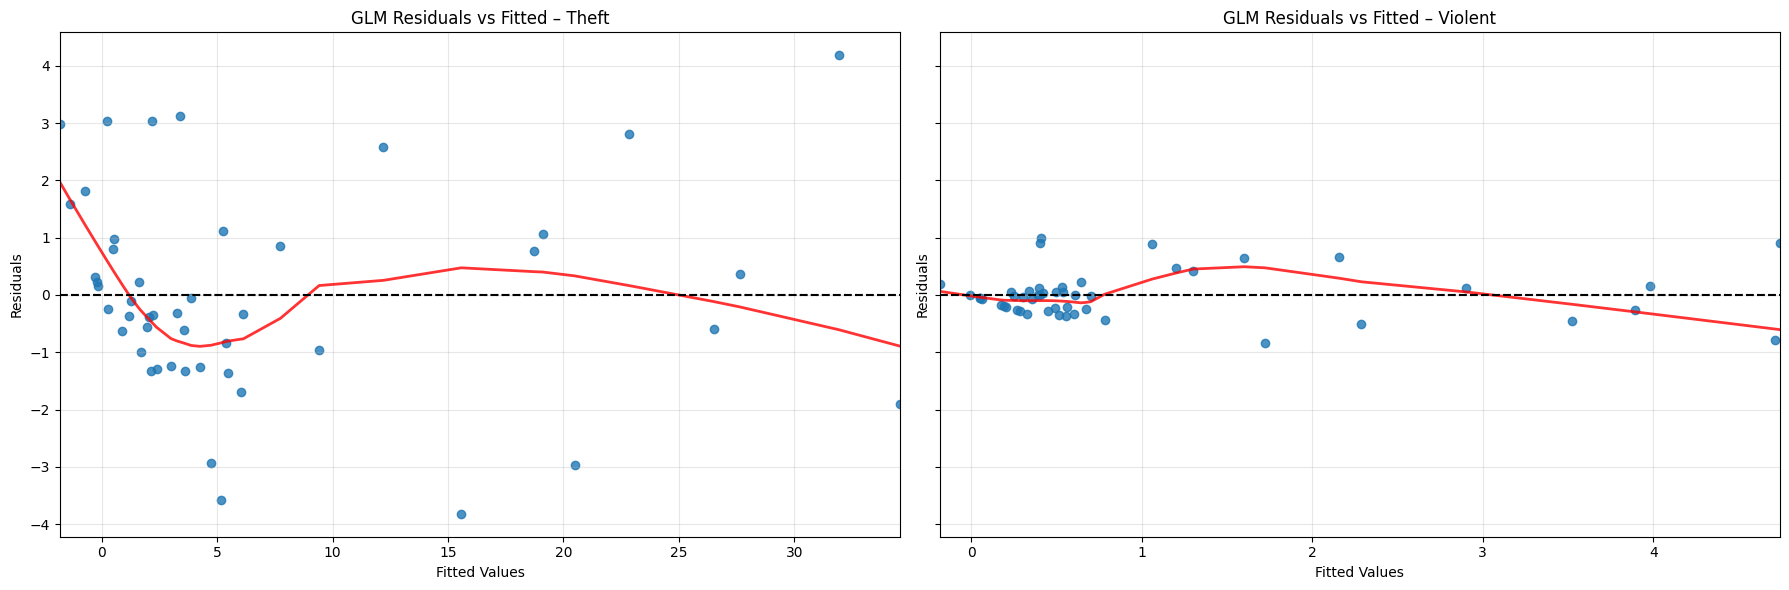

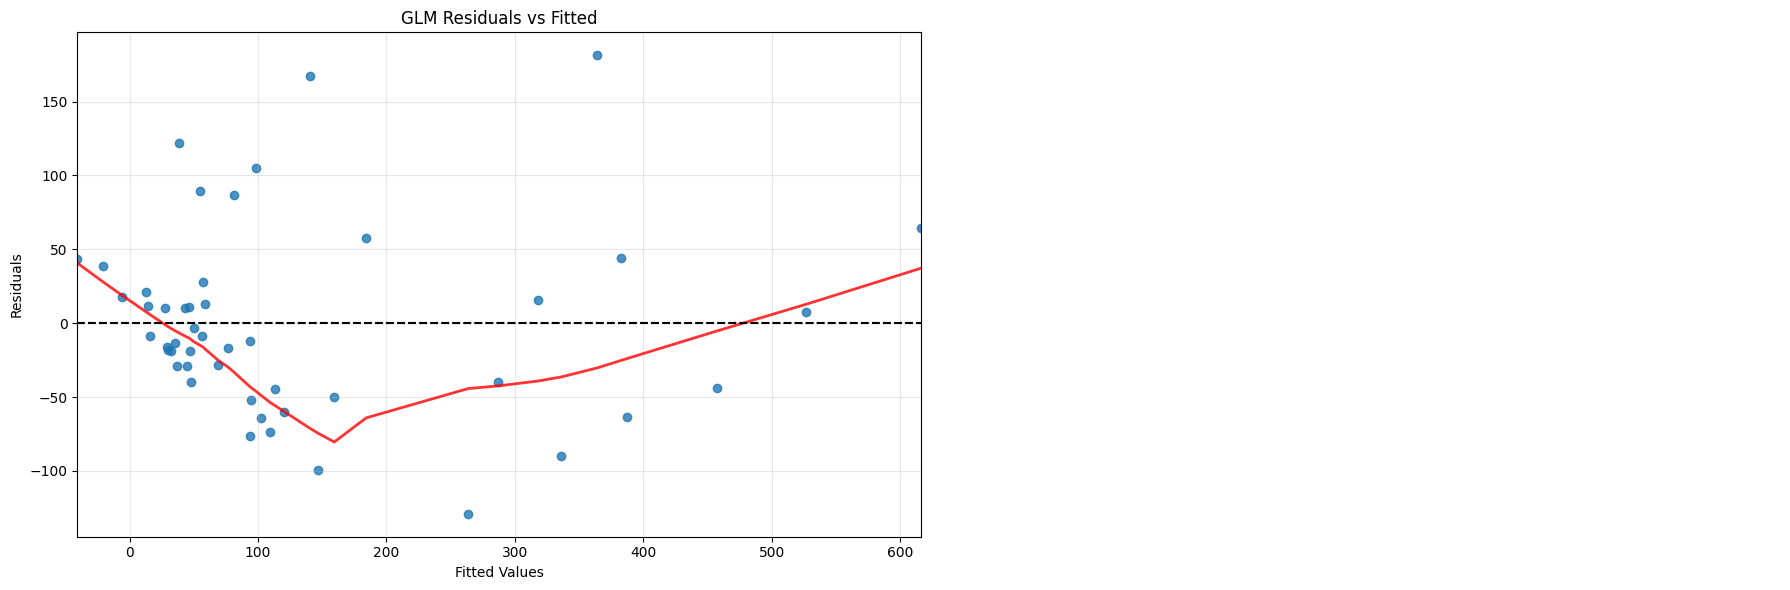

In [445]:
res_vs_fitted_glm_double(glm_burglary, glm_disorder, titles=("Bulglary", "Disorder"))
res_vs_fitted_glm_double(glm_theft, glm_violent, titles=("Theft", "Violent"))
res_vs_fitted_glm_single(glm_other)

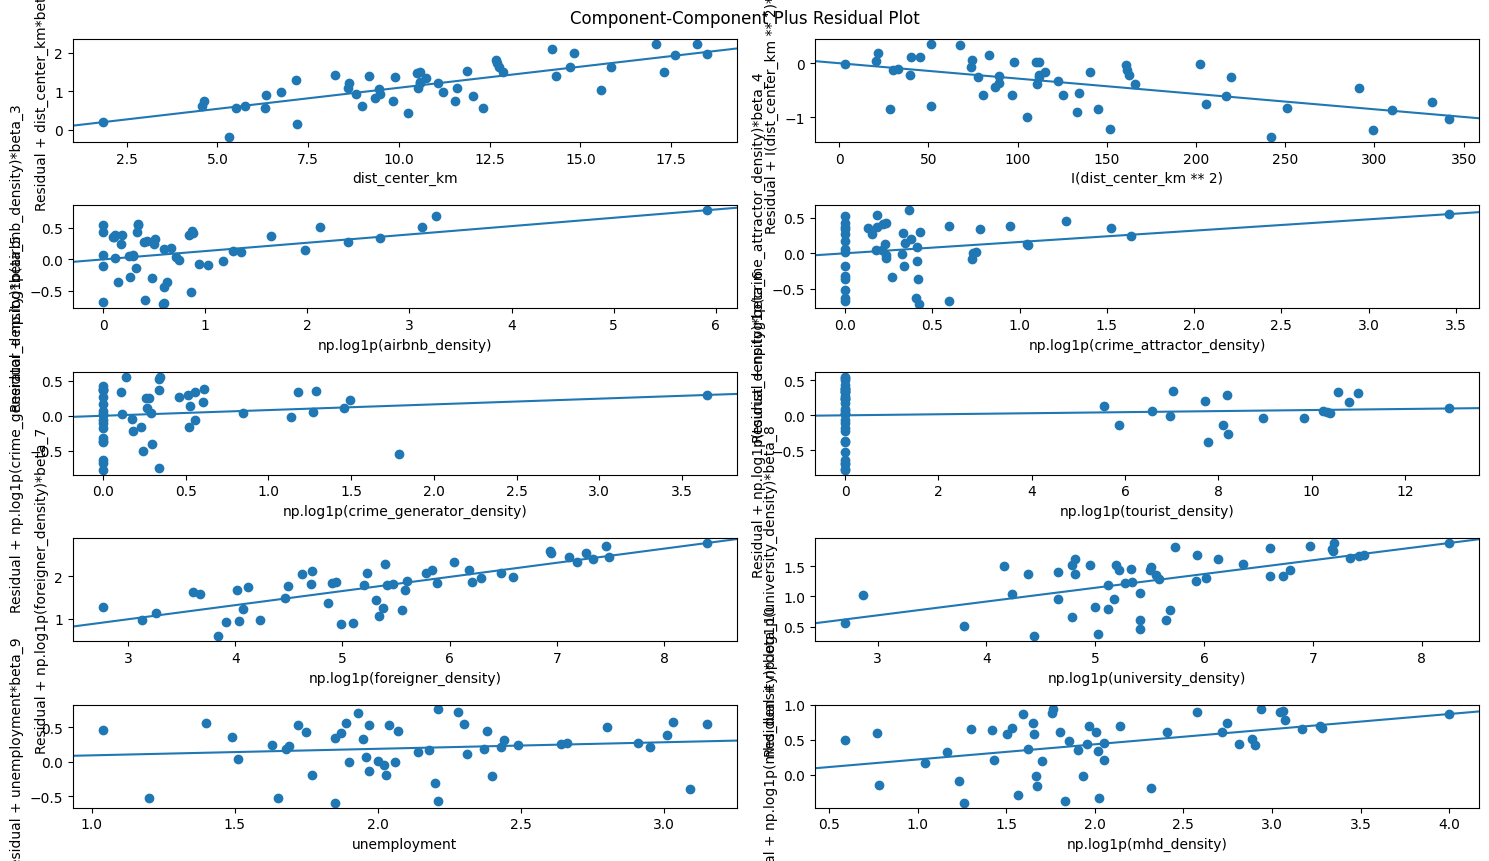

In [446]:
fig = plt.figure(figsize=(15, 10))
sm.graphics.plot_ccpr_grid(lm_disorder, fig=fig)
plt.show()

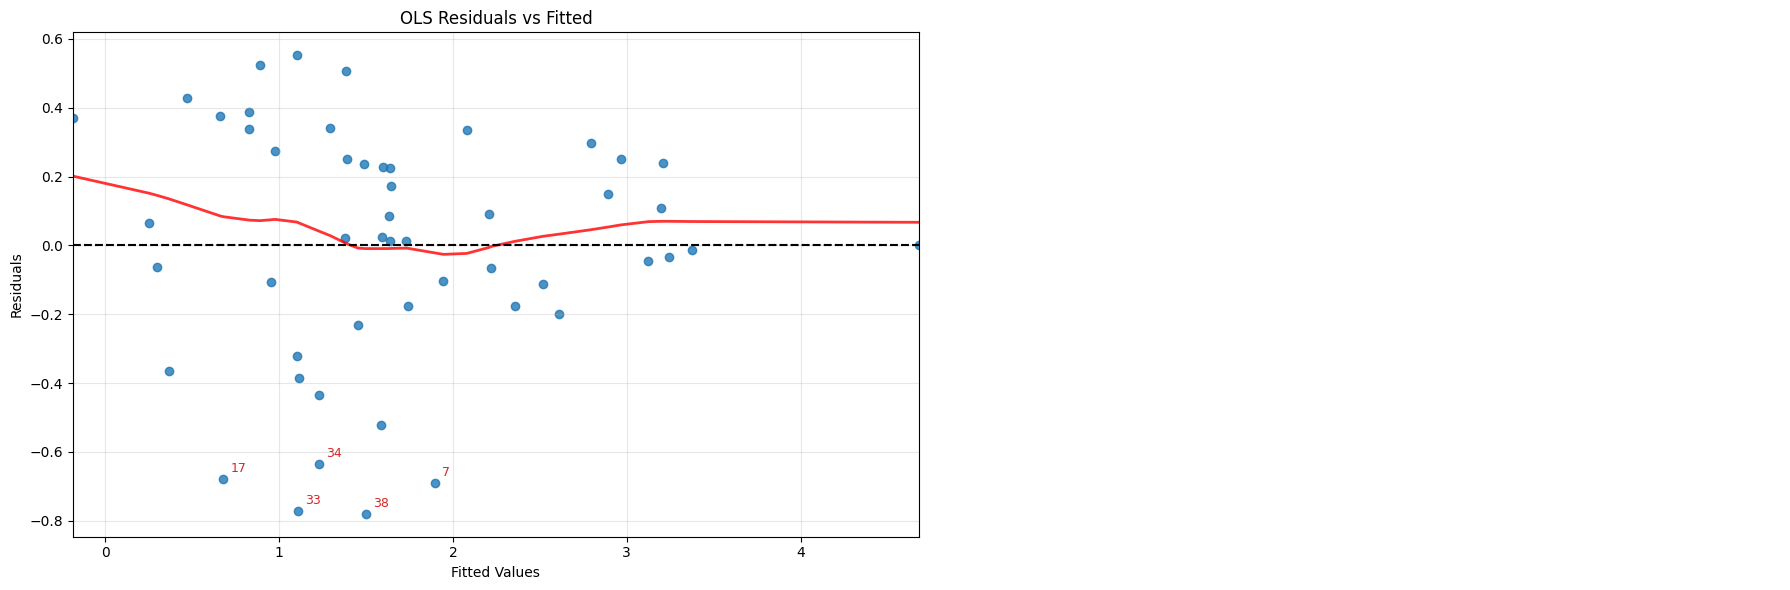

In [447]:
res_vs_fitted_ols_single(lm_disorder)

In [448]:
_, pval, __, ___ = het_breuschpagan(glm_burglary.resid_deviance, glm_burglary.model.exog)
print(f"Breusch-Pagan p-value - burglary: {pval}")

_, pval, __, ___ = het_breuschpagan(glm_disorder.resid_deviance, glm_disorder.model.exog)
print(f"Breusch-Pagan p-value - burglary: {pval}")

_, pval, __, ___ = het_breuschpagan(glm_theft.resid_deviance, glm_theft.model.exog)
print(f"Breusch-Pagan p-value - burglary: {pval}")

_, pval, __, ___ = het_breuschpagan(glm_violent.resid_deviance, glm_violent.model.exog)
print(f"Breusch-Pagan p-value - burglary: {pval}")

_, pval, __, ___ = het_breuschpagan(glm_other.resid_deviance, glm_other.model.exog)
print(f"Breusch-Pagan p-value - burglary: {pval}")

Breusch-Pagan p-value - burglary: 0.05718773153973836
Breusch-Pagan p-value - burglary: 0.09234067958719548
Breusch-Pagan p-value - burglary: 0.03834509087919482
Breusch-Pagan p-value - burglary: 0.01125721734810389
Breusch-Pagan p-value - burglary: 0.012009858343502954


## Feature Selection